In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [2]:
#raw data
data = pd.read_csv('data_daily.csv')
data['# Date'] = pd.to_datetime(data['# Date'])
data['Receipt_Count'] = data['Receipt_Count'].astype('float')

We want to check in our EDA how does the receipt count vary across the timeseries

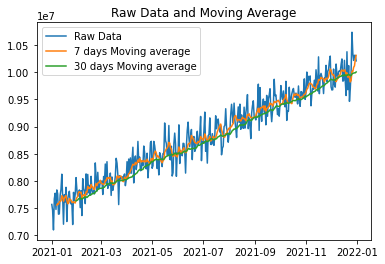

In [3]:
warnings.filterwarnings("ignore")

#simple moving average Data
smadata = data.rolling(7).mean()
smadata['# Date'] = data['# Date']
smadata2 = data.rolling(30).mean()
smadata2['# Date'] = data['# Date']

plt.title('Raw Data and Moving Average')
plt.plot(data['# Date'], data.Receipt_Count, label = 'Raw Data')
plt.plot(smadata['# Date'], smadata.Receipt_Count, label = '7 days Moving average')
plt.plot(smadata2['# Date'], smadata2.Receipt_Count, label = '30 days Moving average')
plt.legend()
plt.show()

The above graph shows a pretty much linear pattern across 2021 obviously some random noise. As we take moving average of the data the noise tends to blur down as the rolling window increases.

Considering that the data is about receipts that a business faces, it is worthwhile to investigate if there are weekly patterns (i.e. Saturday Sunday counts is substantially different from those during weekdays). For the same we decompose the observed timeseries into trend, seasonals and residuals. The seasonal should have a stark patterns with a period of 7 days. 

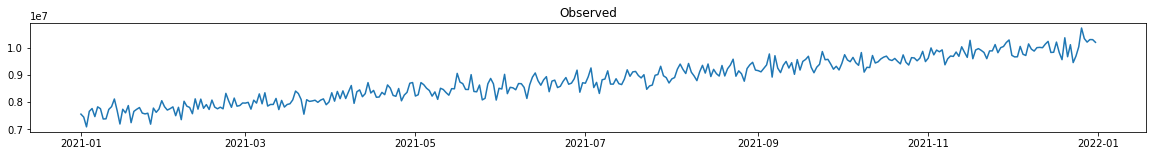

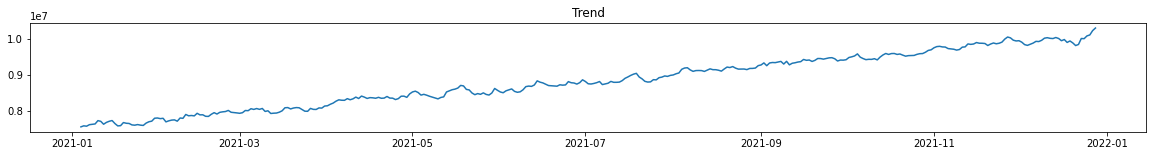

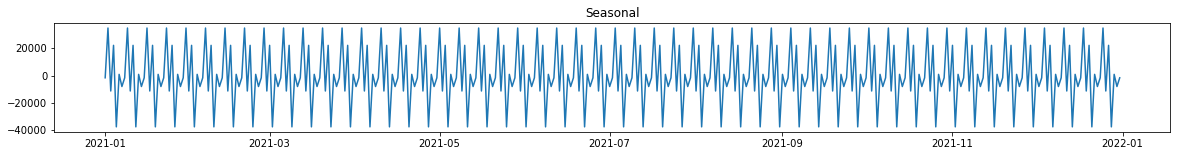

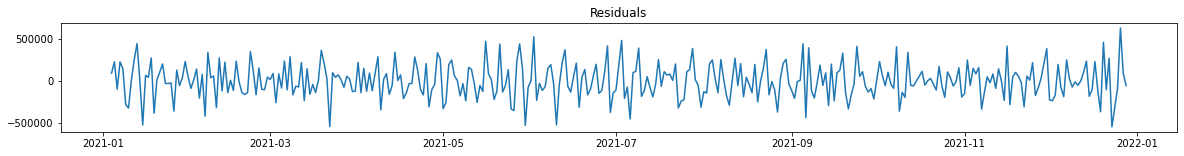

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
data = data.set_index('# Date')
result = seasonal_decompose(data, model='additive')

plt.figure(figsize=(20,2))
plt.title('Observed')
plt.plot(result.observed)
plt.show()

plt.figure(figsize=(20,2))
plt.title('Trend')
plt.plot(result.trend)
plt.show()

plt.figure(figsize=(20,2))
plt.title('Seasonal')
plt.plot(result.seasonal)
plt.show()

plt.figure(figsize=(20,2))
plt.title('Residuals')
plt.plot(result.resid)
plt.show()

We see that there is some seasonality but the residuals have substantial amplitude as well. Becuase we see some seasonality we can engineer features to include the weekday information but it may be corrected by the residuals. We shall benchmark the results of the linear regression model with these weekday information against the model which doesn't to make the final decision.

In [5]:
class LinearRegression() :
    def __init__( self, learning_rate = 0.00002, iterations=1000000) :
        self.learning_rate = learning_rate
        self.iterations = iterations
        
    def fit(self, X, Y):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        if not isinstance(Y, np.ndarray):
            Y = Y.to_numpy()
            
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y
        for i in range(self.iterations):
            self.update_weights()
        return self
            
    def update_weights(self):
#         print(self.W, self.b)
        Y_pred = self.predict(self.X)
        dW = -(2*(self.X.T).dot(self.Y-Y_pred))/self.m
        db = -2*np.sum(self.Y-Y_pred)/self.m 
        self.W = self.W-self.learning_rate*dW
        self.b = self.b-self.learning_rate*db
        return self

    def predict(self,X):
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
#         print(self.W, self.b, X.shape)
        return X.dot(self.W) + self.b

def meansqerror(y,y_pred): # y_pred and y needs to be a numpy array
    return np.sqrt(np.mean((y_pred-y)**2))

Linear Regression without Weekdays
RMSE Score val:  236332.979604759
RMSE Score train:  213429.093834977


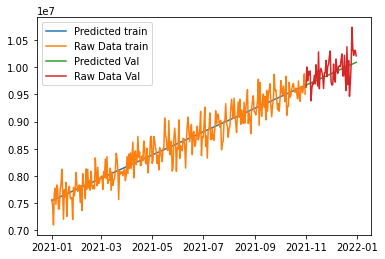

Linear Regression with Weekdays
RMSE Score val:  243733.1436340134
RMSE Score train:  211036.9457876827


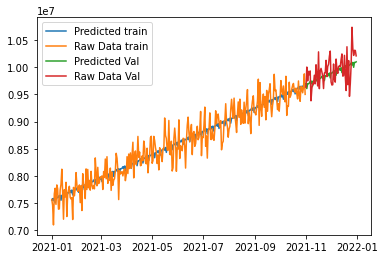

In [6]:
# from sklearn.linear_model import LinearRegression

data['x'] = range(1, data.shape[0]+1)
weekcol = []
for i in data.index.weekday:
    row = [0]*7
    row[i] = 1
    weekcol.append(row)
    
    
data2 = pd.concat([data, pd.DataFrame(np.array(weekcol), index = data.index, dtype = 'float')], axis = 1)

val_data = data2.iloc[-61:]
train_data = data2.iloc[:-61]

reg = LinearRegression().fit(train_data[['x']], train_data.Receipt_Count)
print('Linear Regression without Weekdays')
# print('R2 Score val: ',reg.score(val_data[['x']], val_data.Receipt_Count))
# print('R2 Score train: ',reg.score(train_data[['x']], train_data.Receipt_Count))
print('RMSE Score val: ',meansqerror(reg.predict(val_data[['x']]), val_data.Receipt_Count))
print('RMSE Score train: ',meansqerror(reg.predict(train_data[['x']]), train_data.Receipt_Count))
plt.plot(train_data.index, reg.predict(train_data[['x']]), label = 'Predicted train')
plt.plot(train_data.index, train_data.Receipt_Count, label = 'Raw Data train')
plt.plot(val_data.index, reg.predict(val_data[['x']]), label = 'Predicted Val')
plt.plot(val_data.index, val_data.Receipt_Count, label = 'Raw Data Val')
plt.legend()
plt.show()


reg = LinearRegression().fit(train_data[['x',0, 1, 2, 3, 4, 5, 6]], train_data.Receipt_Count)
print('Linear Regression with Weekdays')
print('RMSE Score val: ',meansqerror(reg.predict(val_data[['x',0, 1, 2, 3, 4, 5, 6]]), val_data.Receipt_Count))
print('RMSE Score train: ',meansqerror(reg.predict(train_data[['x',0, 1, 2, 3, 4, 5, 6]]), train_data.Receipt_Count))
plt.plot(train_data.index, reg.predict(train_data[['x',0, 1, 2, 3, 4, 5, 6]]), label = 'Predicted train')
plt.plot(train_data.index, train_data.Receipt_Count, label = 'Raw Data train')
plt.plot(val_data.index, reg.predict(val_data[['x',0, 1, 2, 3, 4, 5, 6]]), label = 'Predicted Val')
plt.plot(val_data.index, val_data.Receipt_Count, label = 'Raw Data Val')
plt.legend()
plt.show()

We see above that the RMSE score of train dataset improves if we add weekday information but for the validation dataset the same decreases. This indicates that the model is overfitting on train dataset with weekdays. **And it is better to stick without using the weekday features**.
The following code predicts the receipt count daywise and then takes the summation to get the monthwise counts, the code also provides with the comparison of the predictions with true values and the error between both for training and validation dataset.

In [7]:
reg = LinearRegression().fit(train_data[['x']], train_data.Receipt_Count)
print('Training Dataset')
print('Mnth,   True,   Pred,         Error')
train_data[train_data.index.month == 5].Receipt_Count.sum()
train_data_pred = pd.DataFrame(reg.predict(train_data[['x']]), index = train_data.index)
for i in range(1,11):
    print('%s, %.1f, %.1f, %.1f'%(i, train_data[train_data.index.month == i].Receipt_Count.sum(), 
          train_data_pred[train_data_pred.index.month == i][0].sum(),
          train_data[train_data.index.month == i].Receipt_Count.sum()-
          train_data_pred[train_data_pred.index.month == i][0].sum()))
    
print('\nValidation Dataset')
print('Mnth,   True,    Pred,        Error')
val_data[val_data.index.month == 5].Receipt_Count.sum()
val_data_pred = pd.DataFrame(reg.predict(val_data[['x']]), index = val_data.index)
for i in range(11,13):
    print('%s, %.1f, %.1f, %.1f'%(i, val_data[val_data.index.month == i].Receipt_Count.sum(), 
          val_data_pred[val_data_pred.index.month == i][0].sum(),
          val_data[val_data.index.month == i].Receipt_Count.sum()-
          val_data_pred[val_data_pred.index.month == i][0].sum()))

Training Dataset
Mnth,   True,   Pred,         Error
1, 236736687.0, 237092181.4, -355494.4
2, 220033460.0, 219932375.9, 101084.1
3, 248608625.0, 249900936.6, -1292311.6
4, 250644830.0, 248247495.2, 2397334.8
5, 263151748.0, 263143886.8, 7861.2
6, 260656840.0, 261063253.5, -406413.5
7, 274776003.0, 276386837.1, -1610834.1
8, 283943231.0, 283116861.0, 826370.0
9, 281146154.0, 280391938.2, 754215.8
10, 295965185.0, 296359811.3, -394626.3

Validation Dataset
Mnth,   True,    Pred,        Error
11, 296085162.0, 293207696.5, 2877465.5
12, 309948684.0, 309602761.6, 345922.4


The above shows that the error is acceptable (atleast for the current assignment) and we are moving forward with this regression model.
Now that we have satisfactory model in place, we would like to predict the receipt counts in the future. Before we do that, we want to improve our model by adding the validation dataset into the training dataset just so that we have some extra data for our model to work on. We are assuming that the generalized behaviour of our data remains the same and that adding the validation data for training won't make the model overfit.


Raw Data of 2021 and Prediction for 2022


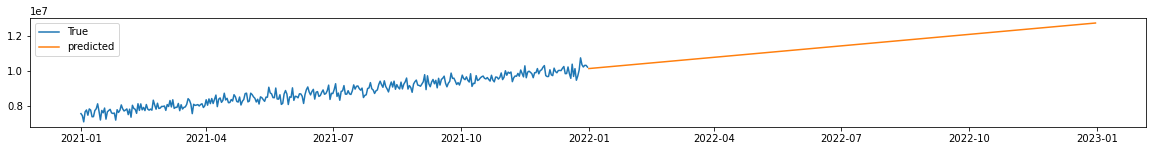


Monthwise Predictions for 2022
January   317332743.7
February  292505506.0
March     330358019.7
April     326217508.1
May       343824830.4
June      339249905.6
July      357291641.2
August    364135430.2
September 358905324.8
October   377602241.0
November  371937722.3
December  391069051.7

Barplot for Monthwise Predictions for 2022


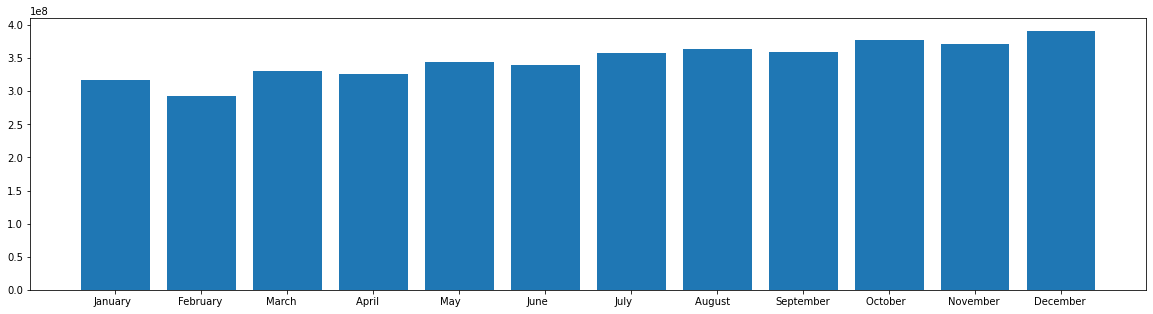

Linear Regression Model Configurations:
Weight/s : [7121.52868447]
bias     : 7523237.690740455


In [8]:
data3 = pd.DataFrame(data2.x.values+365, index = data2.index+pd.DateOffset(days=365))
data3 = data3.rename(columns={0:'x'})
reg = LinearRegression().fit(data2[['x']], data2.Receipt_Count)
print('\nRaw Data of 2021 and Prediction for 2022')
plt.figure(figsize=(20,2))
plt.plot(data2[['Receipt_Count']], label= "True")
plt.plot(data3.index, reg.predict(data3[['x']]), label= "predicted")
plt.legend()
plt.show()

index2mnth = {1:'January  ', 2:'February ', 3:'March    ', 4:'April    ', 5:'May      ', 6:'June     ',
              7:'July     ', 8:'August   ', 9:'September', 10:'October  ', 11:'November ', 12:'December '}

data3_pred = pd.DataFrame(reg.predict(data3[['x']]), index = data3.index)
mnth2count = {}
print('\nMonthwise Predictions for 2022')
for i in range(1,13):
    print('%s %.1f'%(index2mnth[i], data3_pred[data3_pred.index.month == i][0].sum()))
    mnth2count[index2mnth[i]] = data3_pred[data3_pred.index.month == i][0].sum()
    
print('\nBarplot for Monthwise Predictions for 2022')
plt.figure(figsize=(20,5))
plt.bar(mnth2count.keys(), mnth2count.values())
plt.show()

print('Linear Regression Model Configurations:')
print('Weight/s : %s\nbias     : %s'%(reg.W, reg.b))

In [9]:
# reg = LinearRegression().fit(data2[['x']], data2.Receipt_Count)
# print('\nRaw Data of 2021 and Prediction for 2022')
# plt.figure(figsize=(20,2))
# plt.plot(data2[['Receipt_Count']], label= "True")
# plt.plot(data3.index, reg.predict(data3[['x']]), label= "predicted")
# plt.legend()
# plt.show()

# index2mnth = {1:'January  ', 2:'February ', 3:'March    ', 4:'April    ', 5:'May      ', 6:'June     ',
#               7:'July     ', 8:'August   ', 9:'September', 10:'October  ', 11:'November ', 12:'December '}

# data3_pred = pd.DataFrame(reg.predict(data3[['x']]), index = data3.index)
# mnth2count = {}
# print('\nMonthwise Predictions for 2022')
# for i in range(1,13):
#     print('%s %.1f'%(index2mnth[i], data3_pred[data3_pred.index.month == i][0].sum()))
#     mnth2count[index2mnth[i]] = data3_pred[data3_pred.index.month == i][0].sum()
    
# print('\nBarplot for Monthwise Predictions for 2022')
# plt.figure(figsize=(20,5))
# plt.bar(mnth2count.keys(), mnth2count.values())
# plt.show()

### How to make the model better?
* We assume here that the receipt count in future would continue to show linear relationship (i.e. the average per day count would continue to increase with the same rate). This is a good enough assumption based on our EDA for data of 2021. However, the assumption becomes shaky if we want to predict a long future. We may want to based on reasonable assumption that the growth plateaus after some time. In order to pattern this, instead of linear x, we can use exp(-1/ax) that has the qaulity of growth decay.
* We can also try to understand the noise and see if it is truly random or does it have some patterns which we can extract and pattern in our regression model.